<div>
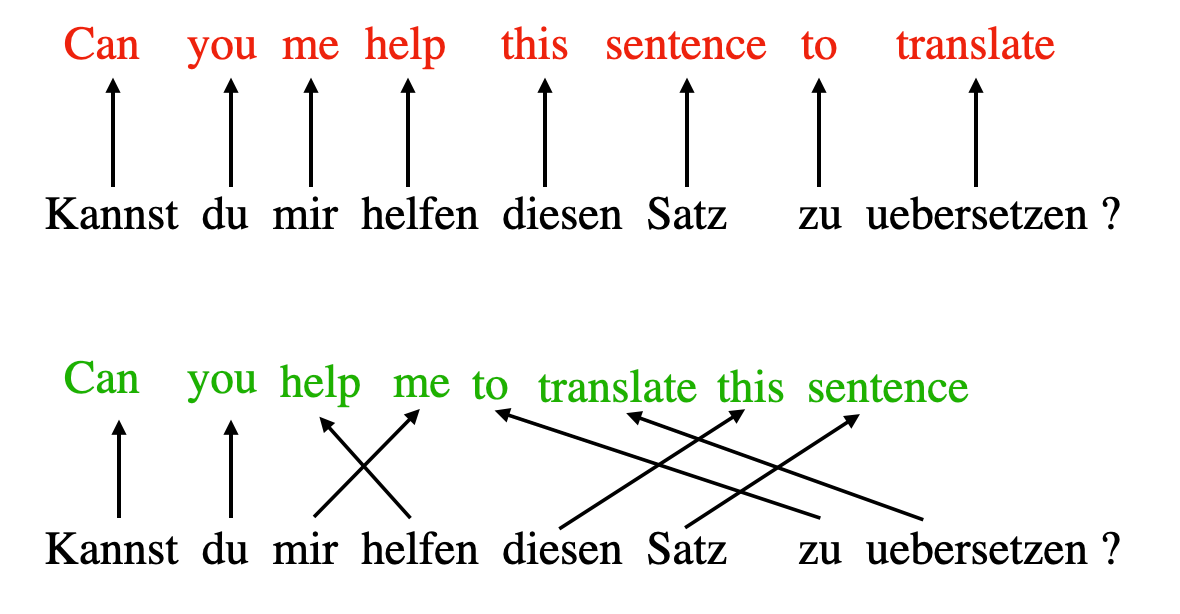
</div>

Translating a sentence word-by-word is usually not an option because it ignores the complex grammatical structures and idiomatic expressions unique to each language, leading to inaccurate or nonsensical translations.

To overcome this issue, attention mechanisms were introduced to give access to all sequence elements at each time step. The key is to be selective and determine which words are most important in a specific context.


<div>
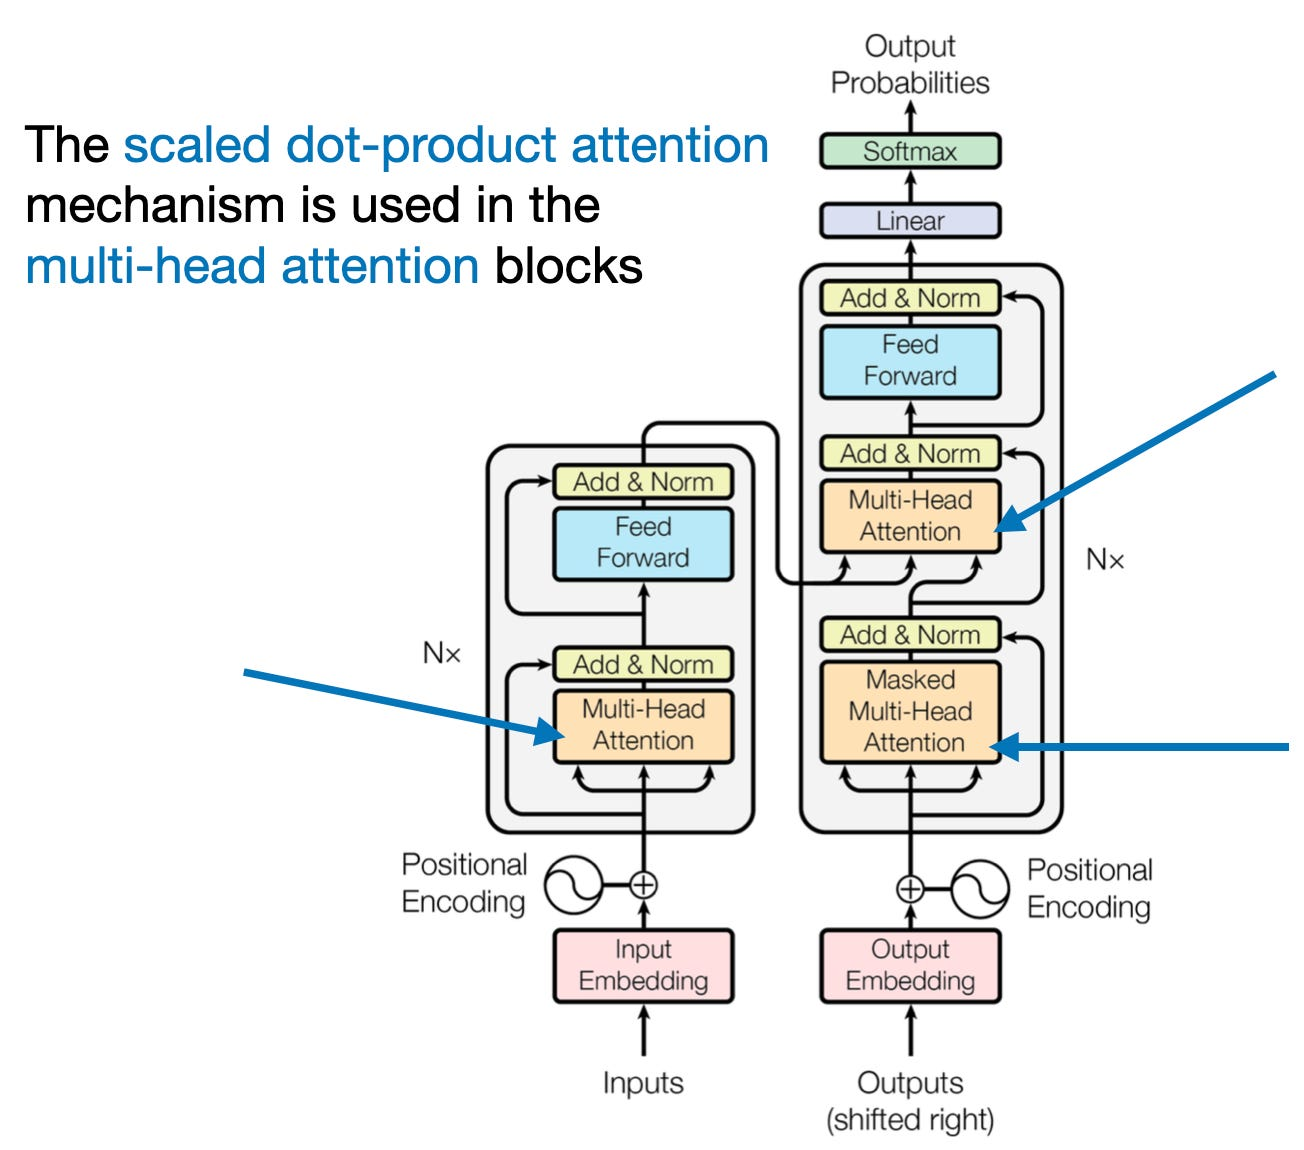
</div>

Self-attention is the heart of Transformers. The self-attention mechanism enables the model to weigh the importance of different elements in an input sequence and dynamically adjust their influence on the output. 

# Self Attention

## Embedding the input

In [42]:
sentence = 'Life is short, eat dessert first'
dc = {s:i for i,s in enumerate(sorted(sentence.replace(',', '').split()))}
print(dc)

{'Life': 0, 'dessert': 1, 'eat': 2, 'first': 3, 'is': 4, 'short': 5}


Next, we use this dictionary to assign an integer index to each word:

In [43]:
import torch

sentence_int = torch.tensor([dc[s] for s in sentence.replace(',', '').split()])
print(sentence_int)

tensor([0, 4, 5, 2, 1, 3])


Using the integer-vector representation of the input sentence, we can use an embedding layer to encode the inputs into a real-vector embedding. Here, we will use a tiny 3-dimensional embedding such that each input word is represented by a 3-dimensional vector. Since the sentence consists of 6 words, this will result in a 6×3-dimensional embedding:

In [44]:
vocab_size = 50_000 #50,000 unique tokens in the vocabulary.

torch.manual_seed(123)
embed = torch.nn.Embedding(vocab_size, 3) #create an embedding layer
embedded_sentence = embed(sentence_int).detach() #function call to converts each integer in sentence_int to its corresponding 3-dimensional embedding.

print(embedded_sentence)
print(embedded_sentence.shape)

tensor([[ 0.3374, -0.1778, -0.3035],
        [ 0.1794,  1.8951,  0.4954],
        [ 0.2692, -0.0770, -1.0205],
        [-0.2196, -0.3792,  0.7671],
        [-0.5880,  0.3486,  0.6603],
        [-1.1925,  0.6984, -1.4097]])
torch.Size([6, 3])


## Weight Matrices
Self-attention utilizes three weight matrices, referred to as Wq, Wk, and Wv, which are adjusted as model parameters during training. The respective query, key and value sequences are obtained via matrix multiplication between the weight matrices W and the embedded inputs x:

Query sequence: q(i) = x(i)Wq for i in sequence 1 … T

Key sequence: k(i) = x(i)Wk for i in sequence 1 … T

Value sequence: v(i) = x(i)Wv for i in sequence 1 … T

The index i refers to the token index position in the input sequence, which has length T.


<div>
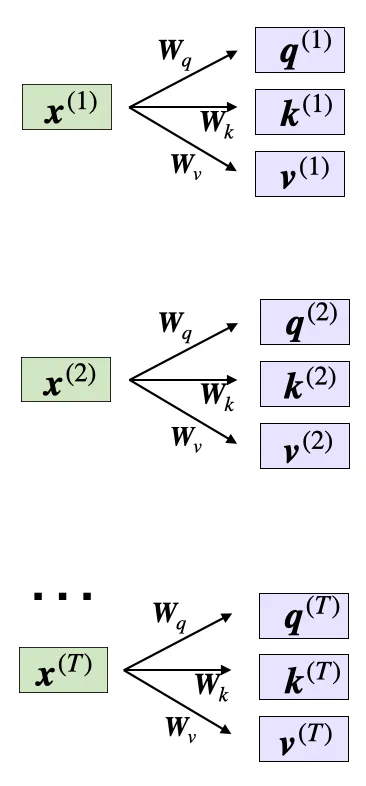
</div>

Here, both q(i) and k(i) are vectors of dimension dk. The projection matrices Wq and Wk have a shape of d × dk , while Wv has the shape d × dv.

(It's important to note that d represents the size of each word vector, x.)

Since we are computing the dot-product between the query and key vectors, these two vectors have to contain the same number of elements (dq = dk). In many LLMs, we use the same size for the value vectors such that dq = dk = dv. However, the number of elements in the value vector v(i), which determines the size of the resulting context vector, can be arbitrary.



So, for the following code walkthrough, we will set dq = dk = dv = 3 initializing the projection matrices as follows:

In [45]:
torch.manual_seed(123)

d = embedded_sentence.shape[1]
print(d)
d_q, d_k, d_v = 3, 3, 3

W_query = torch.nn.Parameter(torch.rand(d, d_q))
W_key = torch.nn.Parameter(torch.rand(d, d_k))
W_value = torch.nn.Parameter(torch.rand(d, d_v))

print(W_query.shape)
print(W_key.shape)
print(W_value.shape)

3
torch.Size([3, 3])
torch.Size([3, 3])
torch.Size([3, 3])


In [46]:
print(W_query)

Parameter containing:
tensor([[0.2961, 0.5166, 0.2517],
        [0.6886, 0.0740, 0.8665],
        [0.1366, 0.1025, 0.1841]], requires_grad=True)


## Computing the Unnormalized Attention Weights
Now, let's suppose we are interested in computing the attention vector for the second input element -- the second input element acts as the query here.


<div>
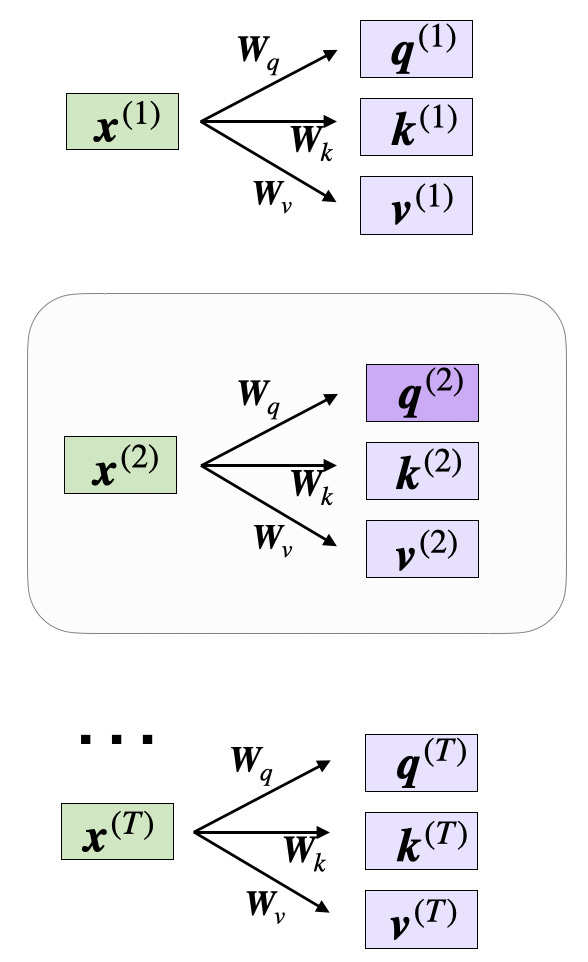
</div>

In [47]:
x_2 = embedded_sentence[1]
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value

print(x_2)
print(query_2.shape)
print(key_2.shape)
print(value_2.shape)

tensor([0.1794, 1.8951, 0.4954])
torch.Size([3])
torch.Size([3])
torch.Size([3])


In [48]:
print(query_2)

tensor([1.4257, 0.2836, 1.7785], grad_fn=<SqueezeBackward4>)


We can then generalize this to compute the remaining key, and value elements for all inputs as well, since we will need them in the next step when we compute the unnormalized attention weights later:

In [49]:
keys = embedded_sentence @ W_key
values = embedded_sentence @ W_value

print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 3])
values.shape: torch.Size([6, 3])


In [50]:
print(keys)

tensor([[ 0.1097,  0.0354, -0.0756],
        [ 0.4727,  0.4880,  1.1328],
        [-0.2202, -0.0513, -0.6837],
        [ 0.1199, -0.0528,  0.3638],
        [-0.1355, -0.0385,  0.2526],
        [-1.3798, -0.4058, -1.7648]], grad_fn=<MmBackward0>)


In [51]:
print(values)

tensor([[-0.0599, -0.0902,  0.0290],
        [ 1.3286,  1.6514,  2.1528],
        [-0.2229, -0.5431, -0.1291],
        [-0.0983,  0.1185, -0.3472],
        [ 0.1634,  0.2683,  0.0239],
        [-0.4284, -1.2711, -0.7229]], grad_fn=<MmBackward0>)


Now that we have all the required keys and values, we can proceed to the next step and compute the unnormalized attention weights ω (omega), which are illustrated in the figure below:


<div>
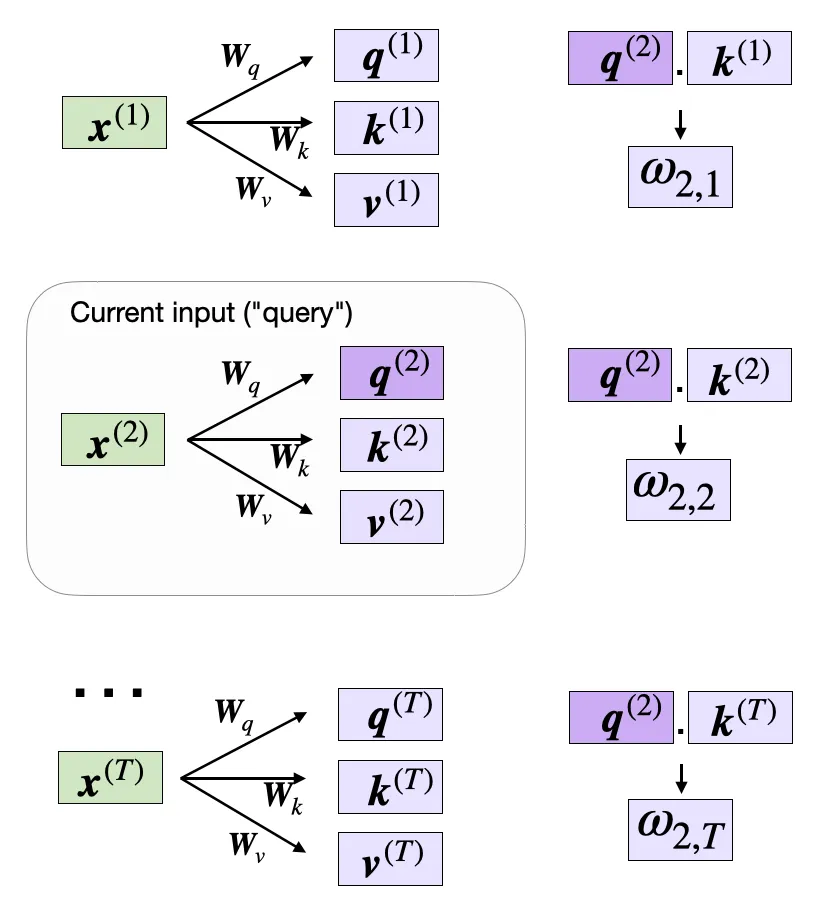
</div>

we compute ωi,j as the dot product between the query and key sequences, ωi,j = q(i) k(j).

Let's compute the ω values for all input tokens

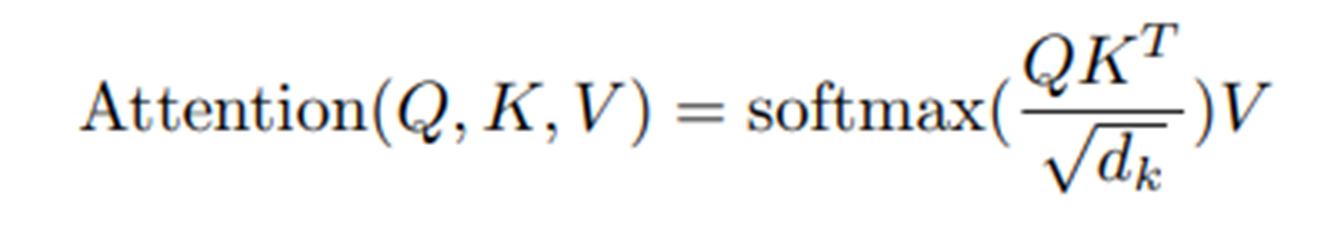

In [52]:
omega_2 = query_2 @ keys.T
print(omega_2)

tensor([ 0.0320,  2.8271, -1.5446,  0.8031,  0.2452, -5.2210],
       grad_fn=<SqueezeBackward4>)


## Normalizing the weights
The subsequent step in self-attention is to normalize the unnormalized attention weights, ω, to obtain the normalized attention weights, α (alpha), by applying the softmax function. The scaling by dk ensures that the Euclidean length of the weight vectors will be approximately in the same magnitude. This helps prevent the attention weights from becoming too small or too large, which could lead to numerical instability or affect the model's ability to converge during training.

In [53]:
import torch.nn.functional as F

attention_weights_2 = F.softmax(omega_2 / d_k**0.5, dim=0)
print(attention_weights_2)

tensor([0.1091, 0.5480, 0.0439, 0.1703, 0.1234, 0.0053],
       grad_fn=<SoftmaxBackward0>)


The last step is to compute the context vector z(2), which is an attention-weighted version of our original query input x(2), including all the other input elements as its context via the attention weights


<div>
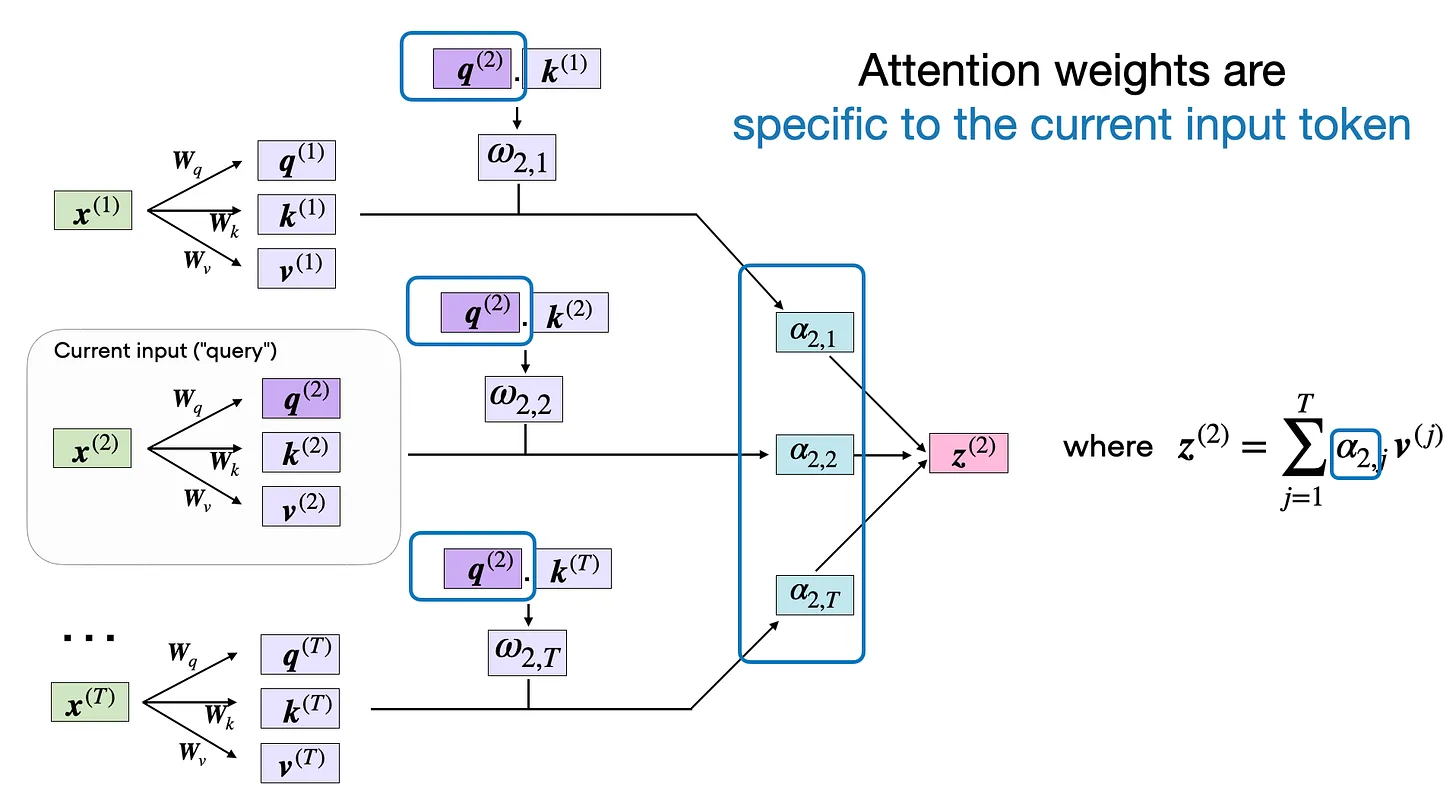
</div>

In [54]:
context_vector_2 = attention_weights_2 @ values

print(context_vector_2.shape)
print(context_vector_2)

torch.Size([3])
tensor([0.7129, 0.9178, 1.1172], grad_fn=<SqueezeBackward4>)


In [20]:
import torch.nn as nn

class SelfAttention(nn.Module):

    def __init__(self, d_in, d_out_kq, d_out_v):
        super().__init__()
        self.d_out_kq = d_out_kq
        self.W_query = nn.Parameter(torch.rand(d_in, d_out_kq))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out_kq))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out_v))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value
        
        attn_scores = queries @ keys.T  # unnormalized attention weights    
        attn_weights = torch.softmax(
            attn_scores / self.d_out_kq**0.5, dim=-1
        )
        
        context_vec = attn_weights @ values
        return context_vec

In [55]:
torch.manual_seed(123)

sa = SelfAttention(3,3,4)
print(sa(embedded_sentence))
print('----')
print(embedded_sentence)

tensor([[ 0.1013,  0.0589, -0.2602,  0.1070],
        [ 0.7576,  1.3422,  0.6583,  0.6907],
        [ 0.0716, -0.0084, -0.3268,  0.0825],
        [ 0.0368, -0.0903, -0.4136,  0.0538],
        [ 0.2005,  0.2913, -0.0318,  0.1813],
        [ 0.0767,  0.0212, -0.2814,  0.0765]], grad_fn=<MmBackward0>)
----
tensor([[ 0.3374, -0.1778, -0.3035],
        [ 0.1794,  1.8951,  0.4954],
        [ 0.2692, -0.0770, -1.0205],
        [-0.2196, -0.3792,  0.7671],
        [-0.5880,  0.3486,  0.6603],
        [-1.1925,  0.6984, -1.4097]])


# Multi-head Attention

In scaled dot-product attention, the input sequence was transformed using three matrices representing the query, key, and value. These three matrices can be considered as a single attention head in the context of multi-head attention. The figure below summarizes this single attention head we covered and implemented previously:

<div>
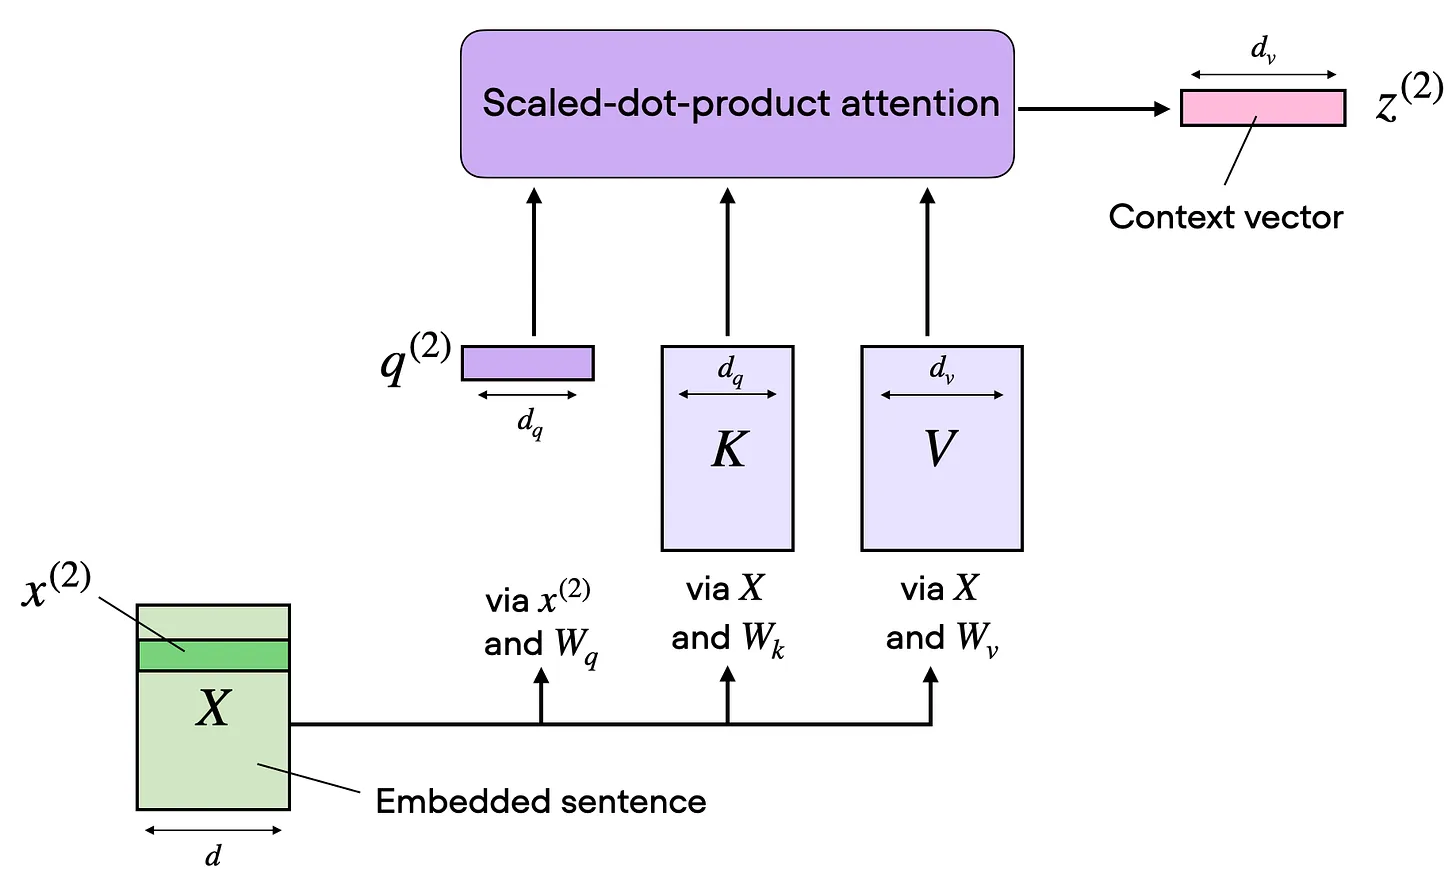
</div>

As its name implies, multi-head attention involves multiple such heads, each consisting of query, key, and value matrices. This concept is similar to the use of multiple kernels in convolutional neural networks, producing feature maps with multiple output channels.


<div>
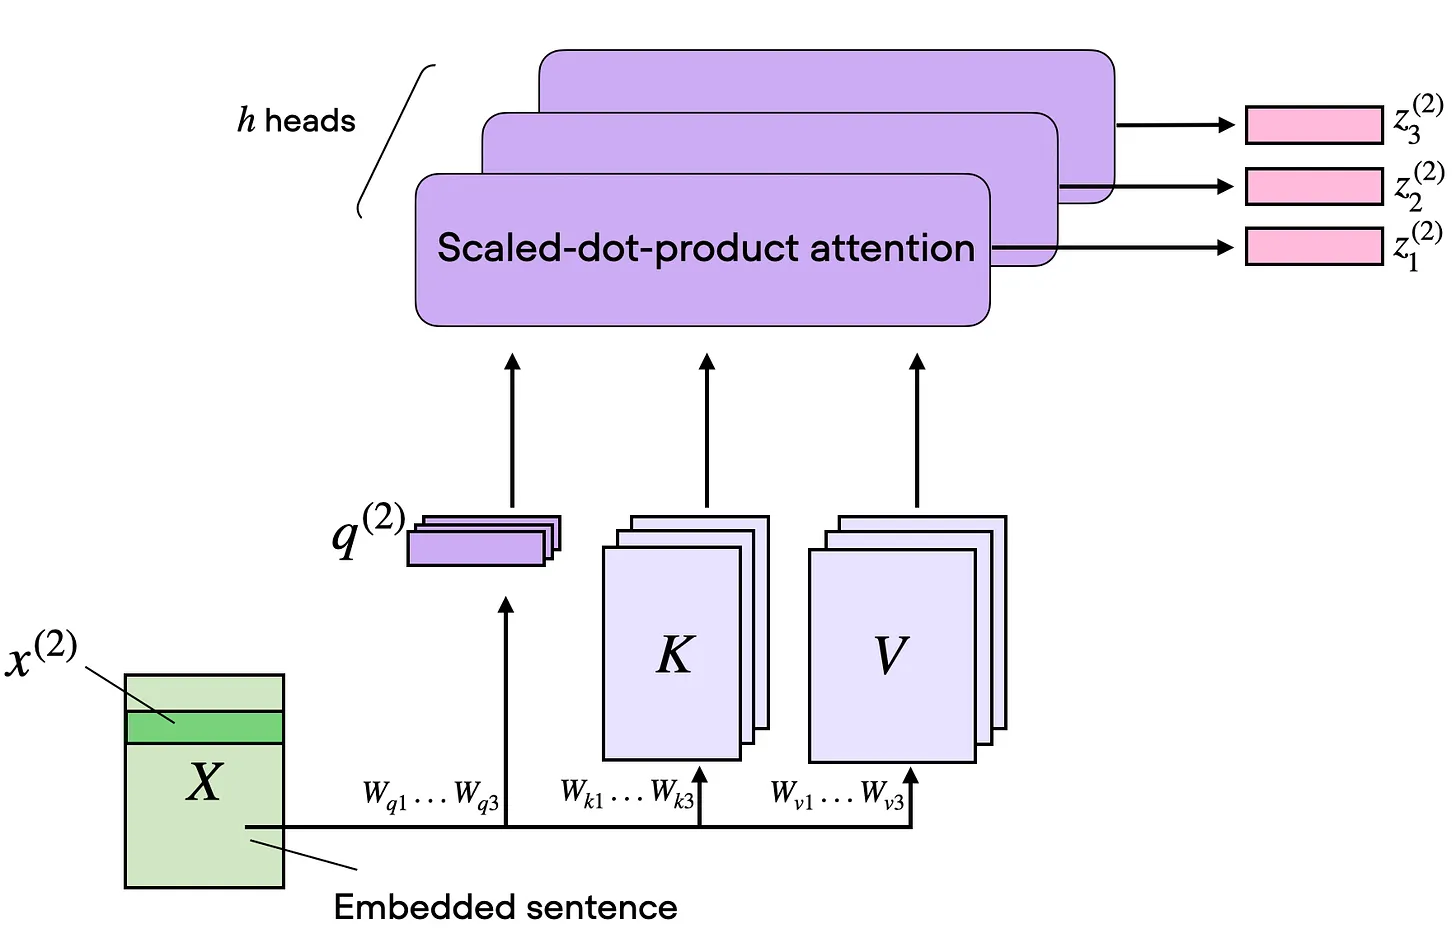
</div>

First, let's suppose we have a single Self-Attention head with output dimension 1 to keep it simple for illustration purposes. 

*d_in:* Dimension of the input feature vector.

*d_out_kq:* Dimension for both query and key outputs.

*d_out_v:* Dimension for value outputs.

*num_heads:* Number of attention heads.

In [56]:
torch.manual_seed(123)

d_in, d_out_kq, d_out_v = 3, 2, 1 #shape would be d x d_in, d x d_out_kq, d x d_out_v

sa = SelfAttention(d_in, d_out_kq, d_out_v)
print(sa(embedded_sentence))

tensor([[-0.0185],
        [ 0.4003],
        [-0.1103],
        [ 0.0668],
        [ 0.1180],
        [-0.1827]], grad_fn=<MmBackward0>)


Now, let's extend this to 4 attention heads:

In [57]:
class MultiHeadAttentionWrapper(nn.Module):

    def __init__(self, d_in, d_out_kq, d_out_v, num_heads):
        super().__init__()
        self.heads = nn.ModuleList(
            [SelfAttention(d_in, d_out_kq, d_out_v) 
             for _ in range(num_heads)]
        )

#Initializes a list of SelfAttention modules. 
#Each SelfAttention module is created with the given d_in, d_out_kq, and d_out_v parameters. 
#The number of such modules is determined by num_heads.

        
    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)

In [58]:
torch.manual_seed(123)

block_size = embedded_sentence.shape[1]
mha = MultiHeadAttentionWrapper(
    d_in, d_out_kq, d_out_v, num_heads=4
)

context_vecs = mha(embedded_sentence)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[-0.0185,  0.0170,  0.1999, -0.0860],
        [ 0.4003,  1.7137,  1.3981,  1.0497],
        [-0.1103, -0.1609,  0.0079, -0.2416],
        [ 0.0668,  0.3534,  0.2322,  0.1008],
        [ 0.1180,  0.6949,  0.3157,  0.2807],
        [-0.1827, -0.2060, -0.2393, -0.3167]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([6, 4])


Notice that the multi-head attention result is a 6×4-dimensional tensor: We have 6 input tokens and 4 self-attention heads, where each self-attention head returns a 1-dimensional output. Previously, in the Self-Attention section, we also produced a 6×4-dimensional tensor. That's because we set the output dimension to 4.

The distinction between increasing the output dimension of a single self-attention head and using multiple attention heads lies in how the model processes and learns from the data. While both approaches increase the capacity of the model to represent different features or aspects of the data, they do so in fundamentally different ways.

For instance, each attention head in multi-head attention can potentially learn to focus on different parts of the input sequence, capturing various aspects or relationships within the data. This diversity in representation is key to the success of multi-head attention.

# Cross Attention

Since the dimensions are sometimes a bit tricky to keep track of, let's summarize everything we have covered so far in the figure below, which depicts the various tensor sizes for a single attention head.


<div>
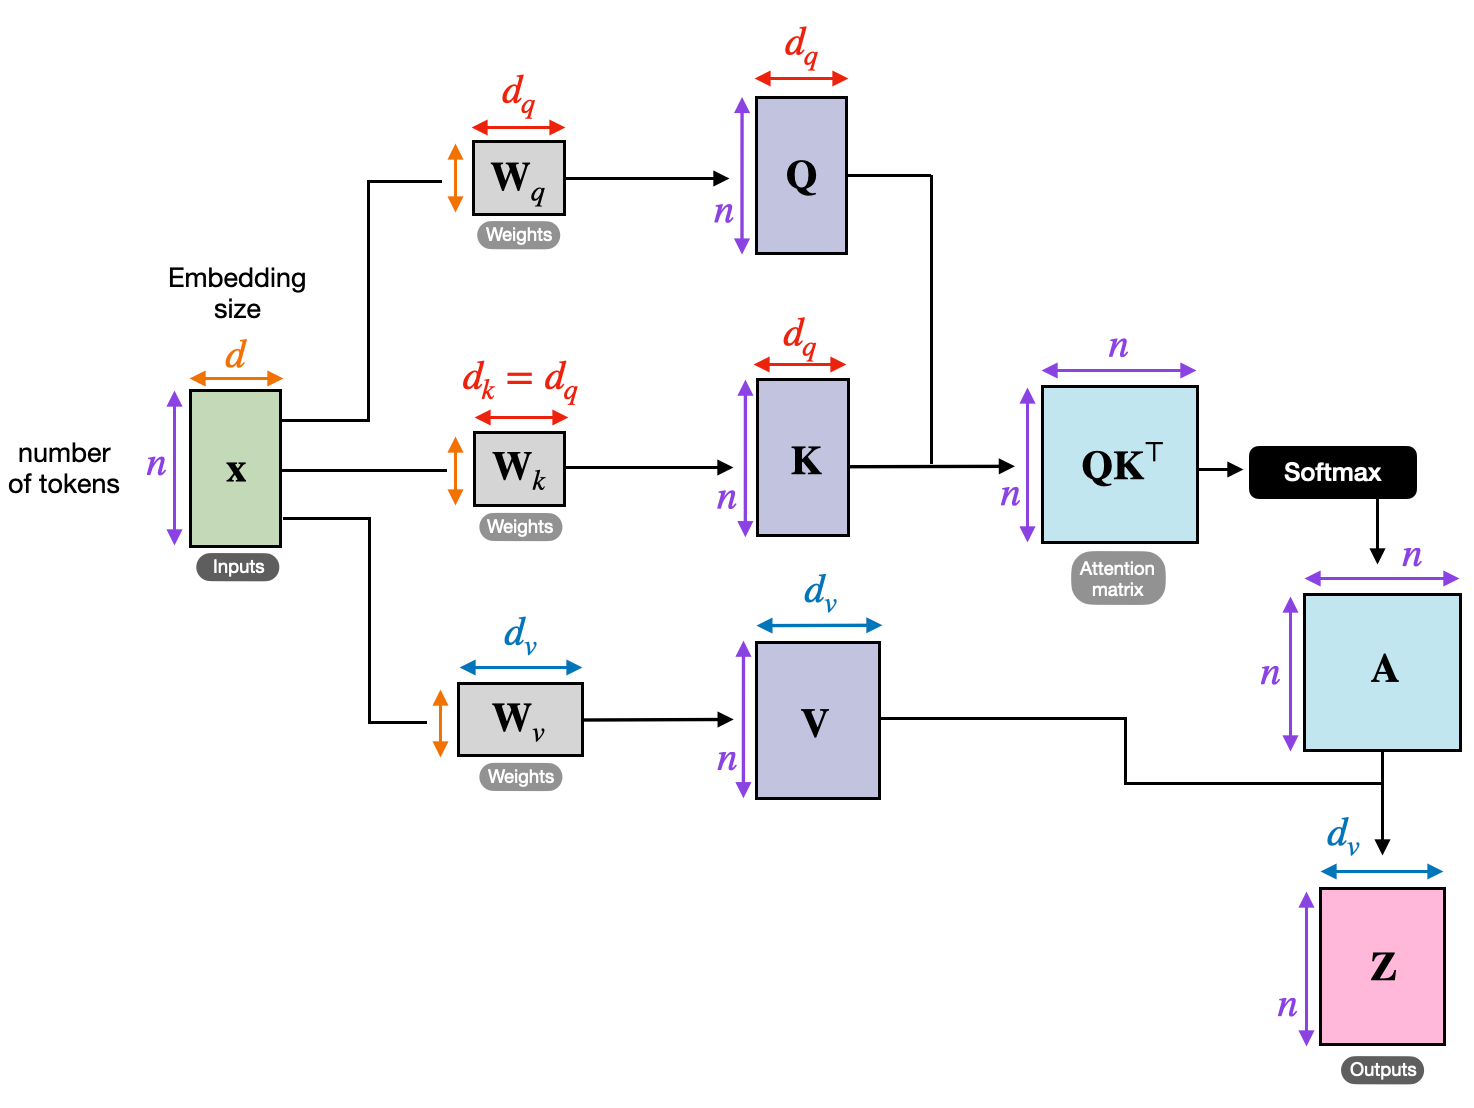
</div>

In self-attention, we work with the same input sequence. In cross-attention, we mix or combine two different input sequences. In the case of the original transformer architecture above, that's the sequence returned by the encoder module on the left and the input sequence being processed by the decoder part on the right.

Note that in cross-attention, the two input sequences x_1 and x_2 can have different numbers of elements. However, their embedding dimensions must match.

The figure below illustrates the concept of cross-attention. If we set x_1 = x_2, this is equivalent to self-attention.


<div>
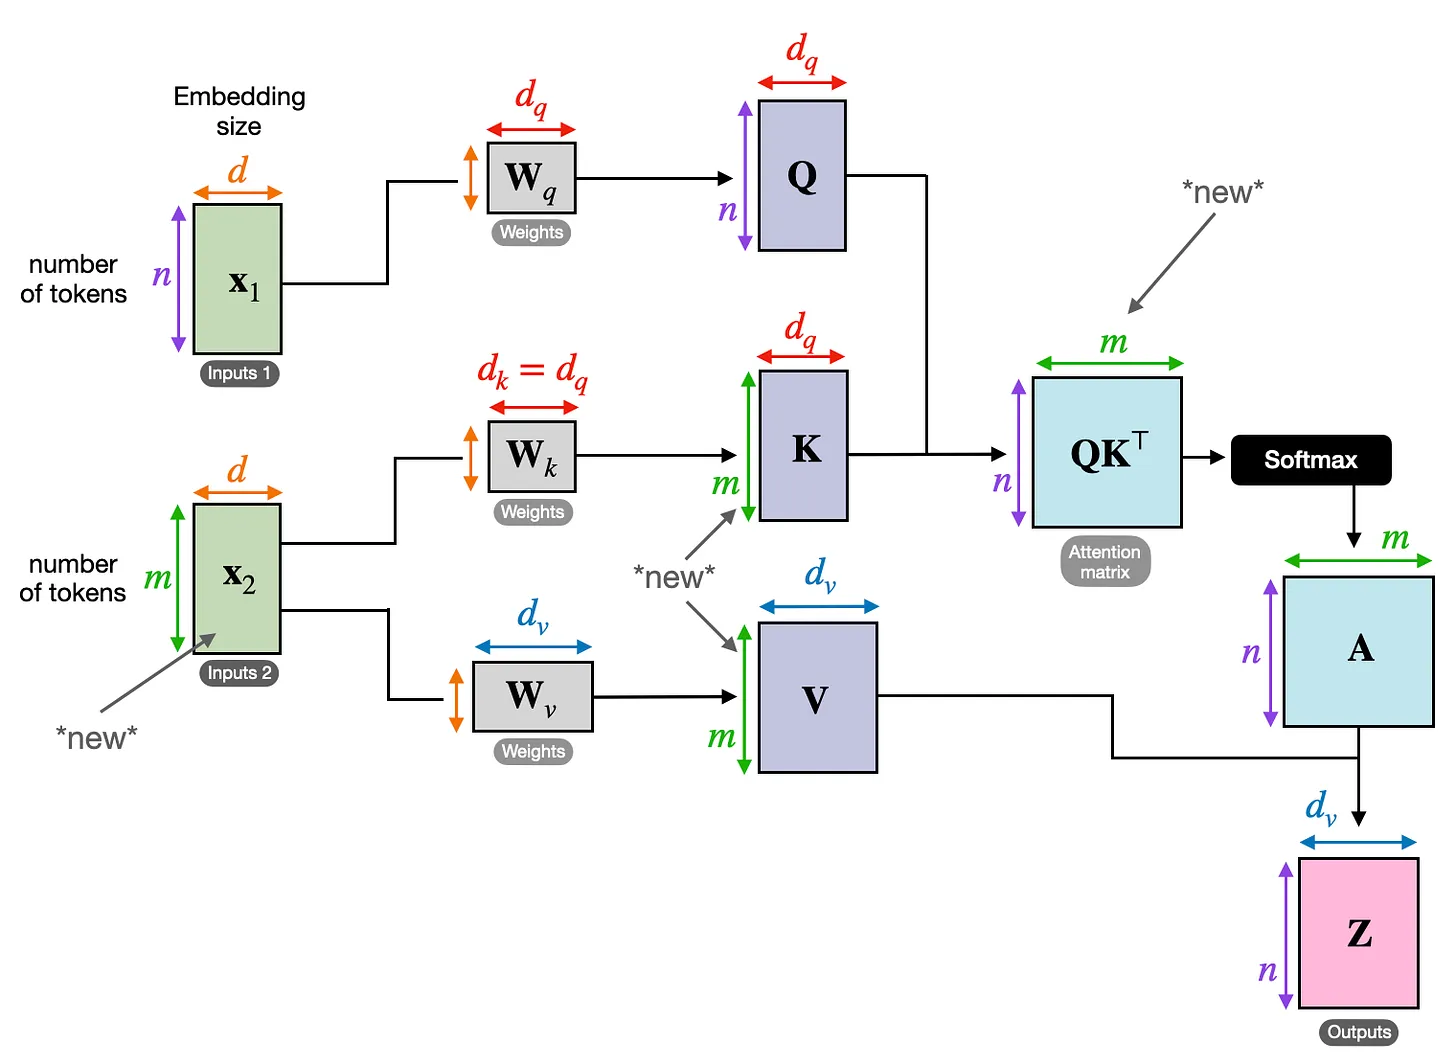
</div>

The queries usually come from the decoder, and the keys and values typically come from the encoder.

In [59]:
class CrossAttention(nn.Module):

    def __init__(self, d_in, d_out_kq, d_out_v):
        super().__init__()
        self.d_out_kq = d_out_kq
        self.W_query = nn.Parameter(torch.rand(d_in, d_out_kq))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out_kq))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out_v))

    def forward(self, x_1, x_2):           # x_2 is new
        queries_1 = x_1 @ self.W_query
        
        keys_2 = x_2 @ self.W_key          # new
        values_2 = x_2 @ self.W_value      # new
        
        attn_scores = queries_1 @ keys_2.T # new 
        attn_weights = torch.softmax(
            attn_scores / self.d_out_kq**0.5, dim=-1)
        
        context_vec = attn_weights @ values_2
        return context_vec

The differences between the CrossAttention class and the previous SelfAttention class are as follows:

The forward method takes two distinct inputs, x_1 and x_2. The queries are derived from x_1, while the keys and values are derived from x_2. This means that the attention mechanism is evaluating the interaction between two different inputs.

The attention scores are calculated by taking the dot product of the queries (from x_1) and keys (from x_2).

Similar to SelfAttention, each context vector is a weighted sum of the values. However, in CrossAttention, these values are derived from the second input (x_2), and the weights are based on the interaction between x_1 and x_2.

In [61]:
torch.manual_seed(123)

d_in, d_out_kq, d_out_v = 3, 2, 4

crossattn = CrossAttention(d_in, d_out_kq, d_out_v)

first_input = embedded_sentence
second_input = torch.rand(8, d_in)

print("First input shape:", first_input.shape)
print("Second input shape:", second_input.shape)

First input shape: torch.Size([6, 3])
Second input shape: torch.Size([8, 3])


In [62]:
context_vectors = crossattn(first_input, second_input)

print(context_vectors)
print("Output shape:", context_vectors.shape)

tensor([[0.4231, 0.8665, 0.6503, 1.0042],
        [0.4874, 0.9718, 0.7359, 1.1353],
        [0.4054, 0.8359, 0.6258, 0.9667],
        [0.4357, 0.8886, 0.6678, 1.0311],
        [0.4429, 0.9006, 0.6775, 1.0460],
        [0.3860, 0.8021, 0.5985, 0.9250]], grad_fn=<MmBackward0>)
Output shape: torch.Size([6, 4])


# Masked multi head attention / Causal self-attention

Causal self-attention ensures that the outputs for a certain position in a sequence is based only on the known outputs at previous positions and not on future positions. In simpler terms, it ensures that the prediction for each next word should only depend on the preceding words.


<div>
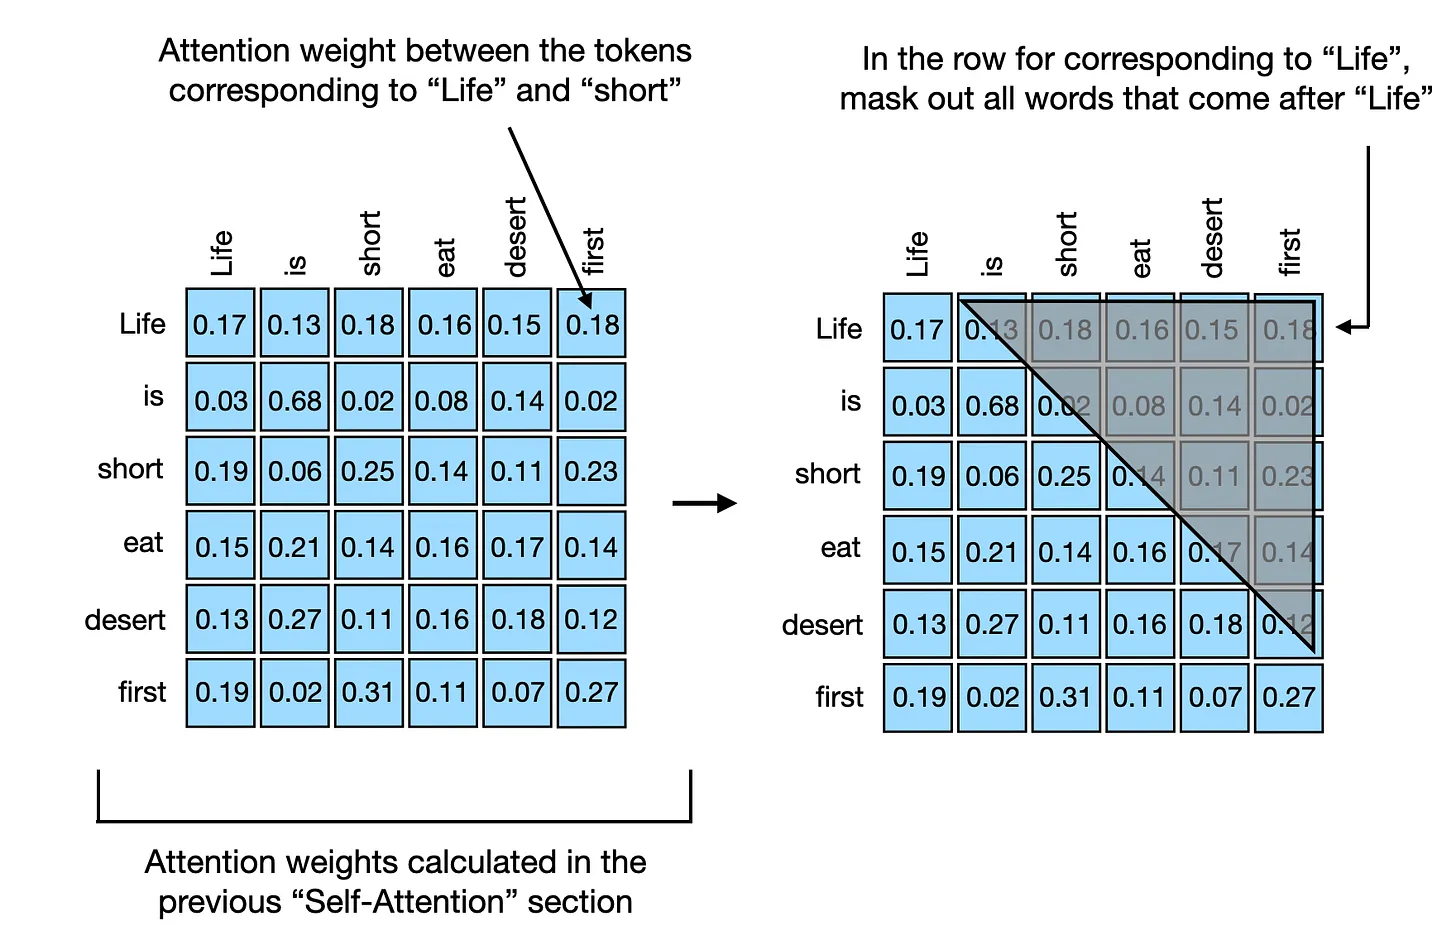
</div>

In [63]:
torch.manual_seed(123)

d_in, d_out_kq, d_out_v = 3, 2, 4

W_query = nn.Parameter(torch.rand(d_in, d_out_kq))
W_key   = nn.Parameter(torch.rand(d_in, d_out_kq))
W_value = nn.Parameter(torch.rand(d_in, d_out_v))

x = embedded_sentence

keys = x @ W_key
queries = x @ W_query
values = x @ W_value

# attn_scores are the "omegas", 
# the unnormalized attention weights
attn_scores = queries @ keys.T 

print(attn_scores)
print(attn_scores.shape)

tensor([[ 0.0613, -0.3491,  0.1443, -0.0437, -0.1303,  0.1076],
        [-0.6004,  3.4707, -1.5023,  0.4991,  1.2903, -1.3374],
        [ 0.2432, -1.3934,  0.5869, -0.1851, -0.5191,  0.4730],
        [-0.0794,  0.4487, -0.1807,  0.0518,  0.1677, -0.1197],
        [-0.1510,  0.8626, -0.3597,  0.1112,  0.3216, -0.2787],
        [ 0.4344, -2.5037,  1.0740, -0.3509, -0.9315,  0.9265]],
       grad_fn=<MmBackward0>)
torch.Size([6, 6])


The output above is a 6×6 tensor containing these pairwise unnormalized attention weights (also called attention scores) for the 6 input tokens.

Previously, we then computed the scaled dot-product attention via the softmax function as follows:

In [64]:
attn_weights = torch.softmax(attn_scores / d_out_kq**0.5, dim=1)
print(attn_weights)

tensor([[0.1772, 0.1326, 0.1879, 0.1645, 0.1547, 0.1831],
        [0.0386, 0.6870, 0.0204, 0.0840, 0.1470, 0.0229],
        [0.1965, 0.0618, 0.2506, 0.1452, 0.1146, 0.2312],
        [0.1505, 0.2187, 0.1401, 0.1651, 0.1793, 0.1463],
        [0.1347, 0.2758, 0.1162, 0.1621, 0.1881, 0.1231],
        [0.1973, 0.0247, 0.3102, 0.1132, 0.0751, 0.2794]],
       grad_fn=<SoftmaxBackward0>)


Now, in GPT-like LLMs, we train the model to read and generate one token (or word) at a time, from left to right. If we have a training text sample like "Life is short eat desert first" we have the following setup, where the context vectors for the word to the right side of the arrow should only incorporate itself and the previous words:

"Life" → "is"

"Life is" → "short"

"Life is short" → "eat"

"Life is short eat" → "desert"

"Life is short eat desert" → "first"


<div>
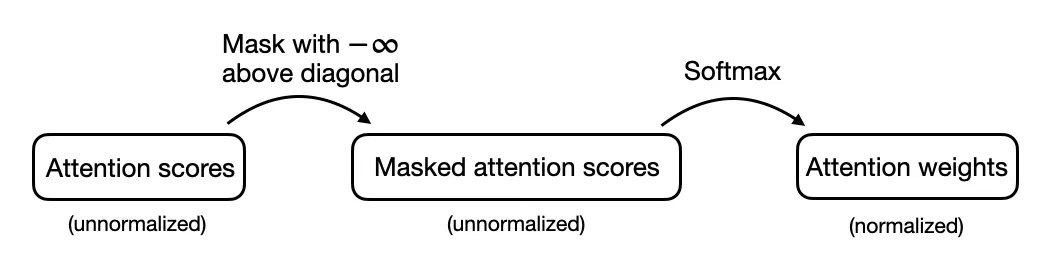
</div>


<div>
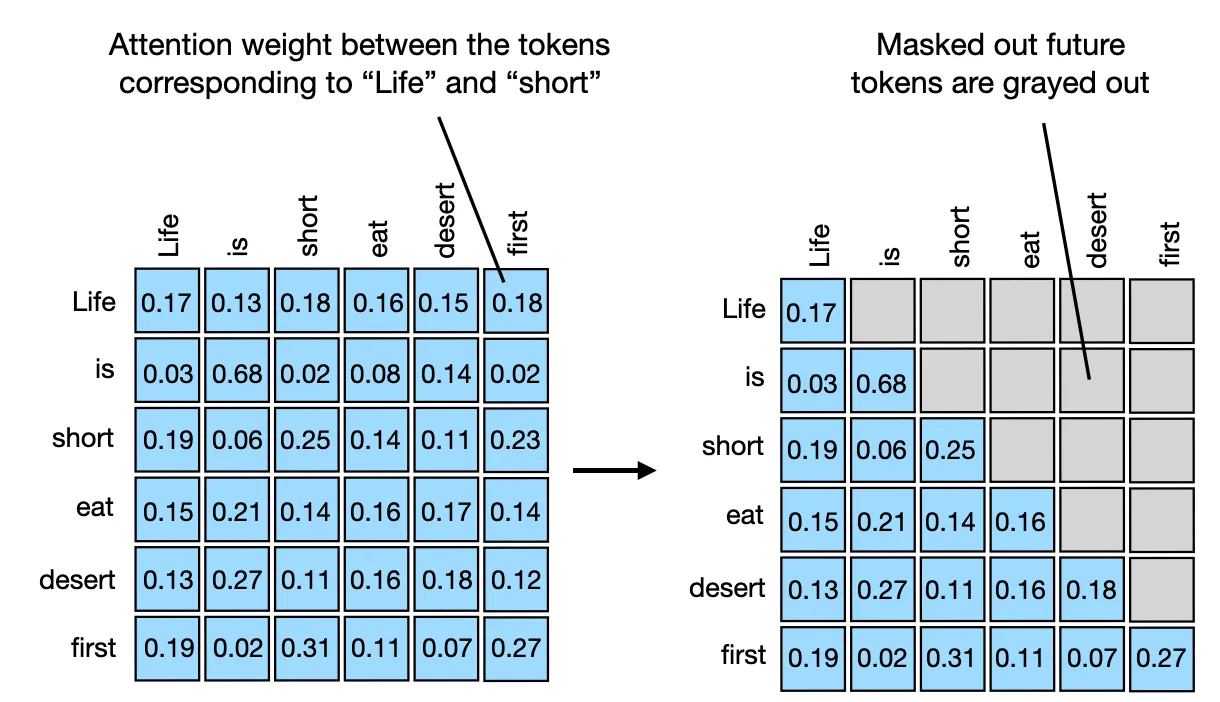
</div>

In [65]:
block_size = attn_scores.shape[0]
mask = torch.triu(torch.ones(block_size, block_size), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[ 0.0613,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.6004,  3.4707,    -inf,    -inf,    -inf,    -inf],
        [ 0.2432, -1.3934,  0.5869,    -inf,    -inf,    -inf],
        [-0.0794,  0.4487, -0.1807,  0.0518,    -inf,    -inf],
        [-0.1510,  0.8626, -0.3597,  0.1112,  0.3216,    -inf],
        [ 0.4344, -2.5037,  1.0740, -0.3509, -0.9315,  0.9265]],
       grad_fn=<MaskedFillBackward0>)


Then, all we have to do is to apply the softmax function as usual to obtain the normalized and masked attention weights:

In [66]:
attn_weights = torch.softmax(masked / d_out_kq**0.5, dim=1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0532, 0.9468, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3862, 0.1214, 0.4924, 0.0000, 0.0000, 0.0000],
        [0.2232, 0.3242, 0.2078, 0.2449, 0.0000, 0.0000],
        [0.1536, 0.3145, 0.1325, 0.1849, 0.2145, 0.0000],
        [0.1973, 0.0247, 0.3102, 0.1132, 0.0751, 0.2794]],
       grad_fn=<SoftmaxBackward0>)
